In [ ]:
import torch

In [1]:
from diffusers import StableDiffusionPipeline

model_path = "/net/scratch/ijain1/diffusion_sat_final_model"
pipe = StableDiffusionPipeline.from_pretrained(model_path, torch_dtype=torch.float16,low_cpu_mem_usage=False, 
                                   device_map=None)
pipe.to("cuda")

image = pipe(prompt="jynx pokemon").images[0]
image.save("yoda-pokemon-1.png")

/home/ijain1/miniconda3/envs/diffsat/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The config attributes {'addition_time_embed_dim': None, 'attention_type': 'default', 'dropout': 0.0, 'encoder_hid_dim_type': None, 'num_attention_heads': None, 'reverse_transformer_layers_per_block': None, 'transformer_layers_per_block': 1} were passed to UNet2DModel, but are not expected and will be ignored. Please verify your config.json configuration file.


ValueError: cross_attention_dim must be specified for CrossAttnDownBlock2D

In [31]:
import torch
from diffusers import UNet2DModel, DDPMScheduler
from PIL import Image
import numpy as np

# Load the model and scheduler (use the method that worked for you)
unet = UNet2DModel.from_pretrained("/net/scratch/ijain1/diffusion_sat_final_model/unet", 
                                   low_cpu_mem_usage=False, 
                                   device_map=None)
scheduler = DDPMScheduler.from_pretrained("/net/scratch/ijain1/diffusion_sat_final_model/scheduler")

# Move the model to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
unet.to(device)

In [38]:
# Set up generation parameters
image_size = 128  # or whatever size you trained on
batch_size = 1
num_inference_steps = 1000  # You can adjust this, fewer steps = faster but potentially lower quality

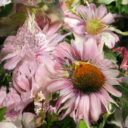

In [39]:
# Generate random noise
noise = torch.randn(
    (batch_size, unet.config.in_channels, image_size, image_size)
).to(device)

# Set number of steps
scheduler.set_timesteps(num_inference_steps)

# Denoise the image
image = noise
for t in scheduler.timesteps:
    # Predict the noise residual
    with torch.no_grad():
        noise_pred = unet(image, t).sample
    
    # Update sample with step
    image = scheduler.step(noise_pred, t, image).prev_sample

# Convert to PIL Image
image = (image / 2 + 0.5).clamp(0, 1)
image = image.cpu().permute(0, 2, 3, 1).numpy()
image = (image * 255).round().astype("uint8")
image = Image.fromarray(image[0])

In [ ]:
image